# Part 0: Differentiation

First, it is important to understand differentiations.

## Exercise 1:
$$  
y = x^Tx,  \quad x \in \mathbb{R}^N
$$

$$
\frac{\partial y}{\partial x} = 2x
$$

## Exercise 2:
$$ y = tr(AB) \quad A,B \in \mathbb{R}^{N \times N} $$

$$
\frac{\partial}{\partial a_{ij}} y = bji
$$

$$
\frac{dy}{dA} = B^T
$$

## Exercise 3:
$$  
y = x^TAc , \quad A\in \mathbb{R}^{N \times N}, x\in \mathbb{R}^{N}, c\in \mathbb{R}^{N}
$$

$$
\frac{dy}{dA} = xc^T
$$

## Exercise 4:
$$
J = || X - AS ||_2^2  , \quad A\in \mathbb{R}^{N \times R} , \quad S\in \mathbb{R}^{R \times M}
$$

$$
\frac{dJ}{dS} = 2A^T(AS−X)
$$

# Part 1: Build Your Own Deep Learning Framework

## Objective
We have seen how to write a Neural Network using raw NumPy (hard) and PyTorch (easy). To truly understand what happens inside `loss.backward()`, you will build a mini-PyTorch from scratch using NumPy.

## Instructions
1.  **Do not use PyTorch, TensorFlow, or Autograd.** Use only `numpy`.
2.  We provide the structure (`Module`, `Sequential`).
3.  You must implement the `updateOutput` (Forward) and `updateGradInput`/`accGradParameters` (Backward) for:
    * `Linear` (Dense Layer)
    * `ReLU` (Activation)
    * `SoftMax` (Activation)
    * `CrossEntropyCriterion` (Loss)
4.  Finally, train a model on the MNIST dataset using your framework.

In [ ]:
import numpy as np

class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        return self.updateOutput(input)

    def backward(self, input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateOutput(self, input):
        raise NotImplementedError()

    def updateGradInput(self, input, gradOutput):
        raise NotImplementedError()

    def accGradParameters(self, input, gradOutput):
        return

    def zeroGradParameters(self):
        return

    def getParameters(self):
        return []

    def getGradParameters(self):
        return []

    def train(self):
        self.training = True

    def evaluate(self):
        self.training = False

class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.output = input
        for module in self.modules:
            self.output = module.forward(self.output)
        return self.output

    def backward(self, input, gradOutput):
        inputs = [input]
        for i in range(len(self.modules) - 1):
            inputs.append(self.modules[i].output)
        self.gradInput = gradOutput
        for i in range(len(self.modules) - 1, -1, -1):
            self.gradInput = self.modules[i].backward(inputs[i], self.gradInput)
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        params = []
        for m in self.modules:
            params += m.getParameters()
        return params

    def getGradParameters(self):
        grads = []
        for m in self.modules:
            grads += m.getGradParameters()
        return grads

## Task 1: Linear Layer
Implement the fully connected layer.
Formula: $Y = X W^T + b$

In [ ]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()

        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)

        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW = gradOutput.T @ input
        self.gradb = gradOutput.sum(axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f'Linear {self.W.shape[1]} -> {self.W.shape[0]}'

## Task 2: Activation Functions
Implement ReLU and SoftMax.
**SoftMax Hint:** Subtract the max value from the input before exponentiating to avoid numerical overflow.
$$\text{SoftMax}(x_i) = \frac{e^{x_i - \max(x)}}{\sum e^{x_j - \max(x)}}$$

In [ ]:
class ReLU(Module):
    def updateOutput(self, input):
        self.output = np.maximum(0, input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * (input > 0)
        return self.gradInput

class SoftMax(Module):
    def updateOutput(self, input):
        shifted = input - np.max(input, axis=1, keepdims=True)
        exp_scores = np.exp(shifted)
        self.output = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        s = self.output
        dot = np.sum(gradOutput * s, axis=1, keepdims=True)
        self.gradInput = s * (gradOutput - dot)
        return self.gradInput

## Task 3: Criterion (Loss Function)
Implement the Negative Log Likelihood (Cross Entropy) for multiclass classification.

In [ ]:
class ClassNLLCriterion(object):
    def __init__(self):
        self.output = None
        self.gradInput = None

    def updateOutput(self, input, target):
        eps = 1e-15
        input_clamp = np.clip(input, eps, 1 - eps)
        N = input.shape[0]
        if target.ndim == 2:
            self.output = -np.sum(target * np.log(input_clamp)) / N
        else:
            self.output = -np.mean(np.log(input_clamp[np.arange(N), target]))
        return self.output

    def updateGradInput(self, input, target):
        N = input.shape[0]
        eps = 1e-15
        input_clamp = np.clip(input, eps, 1 - eps)
        if target.ndim == 2:
            self.gradInput = -target / input_clamp / N
        else:
            self.gradInput = np.zeros_like(input)
            self.gradInput[np.arange(N), target] = -1 / input_clamp[np.arange(N), target]
            self.gradInput /= N
        return self.gradInput

## Task 4: Putting it all together (MNIST)
1. Load MNIST data (use `sklearn.datasets.load_digits` or `torchvision`).
2. Preprocess: Normalize to [0,1], One-hot encode targets.
3. Build a `Sequential` model: Linear -> ReLU -> Linear -> SoftMax.
4. Write a training loop using SGD.
5. Plot the loss.

Epoch 0, Loss: 2.1526
Epoch 10, Loss: 0.2053
Epoch 20, Loss: 0.1198
Epoch 30, Loss: 0.0890
Epoch 40, Loss: 0.0701
Epoch 50, Loss: 0.0572
Epoch 60, Loss: 0.0485
Epoch 70, Loss: 0.0411
Epoch 80, Loss: 0.0349
Epoch 90, Loss: 0.0302


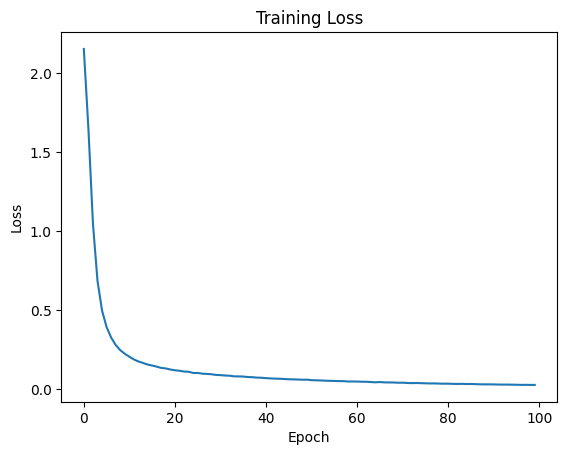

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X = X / 16.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

net = Sequential()
net.add(Linear(64, 32))
net.add(ReLU())
net.add(Linear(32, 10))
net.add(SoftMax())

criterion = ClassNLLCriterion()

learning_rate = 0.1
epochs = 100
batch_size = 32
losses = []

for i in range(epochs):
    epoch_loss = 0
    shuffled_indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[shuffled_indices]
    y_train_shuffled = y_train[shuffled_indices]

    for j in range(0, X_train.shape[0], batch_size):
        x_batch = X_train_shuffled[j:j+batch_size]
        y_batch = y_train_shuffled[j:j+batch_size]

        output = net.forward(x_batch)
        loss = criterion.updateOutput(output, y_batch)
        epoch_loss += loss

        gradOutput = criterion.updateGradInput(output, y_batch)
        net.zeroGradParameters()
        net.backward(x_batch, gradOutput)

        params = net.getParameters()
        grads = net.getGradParameters()
        for p, g in zip(params, grads):
            p -= learning_rate * g

    losses.append(epoch_loss / (X_train.shape[0] // batch_size + 1))
    if i % 10 == 0:
        print(f'Epoch {i}, Loss: {losses[-1]:.4f}')

plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()